# **Text Mining Project**
##### _**Opinion Mining Project, using XED Dataset for Multiclass Emotion Detection**_
`PUZZLES  Team: António Cymbron (r20181059) | Duarte Redinha (r20181066) | Maria João M. Marques (r20181119)`

_"We'll call it, Puzzles!" "Why Puzzles?" "That's the puzzle!"_ (HIMYM, 4x13)

---


The elaboration of the present code was made easier due to several sources and authors, from which we give our special thanks to our Text Mining Professor, Vânia Mendonça, for the available materials that were especially helpful on the part of data pre-processing and feature extraction; to Sandipan Dey, for its contribution on Stackoverflow (2022, March 27), and to the Language Technology at the University of Helsinki, for their contribution on GitHub (2022, May 19), that were both a precious help on using BERT with an unbalanced dataset, by using class weights; to _Thetechwriters_, from AnalyticsVidhya (December 20, 2021) for the BERT insights; to _Pedregosa et al._, from Scikit-learn: Machine Learning in Python (JMLR 12, pp. 2825-2830, 2011) for the valuable tutorials; and to _rashida048_ from _regenerativetoday.com_ (September 7, 2021), for the insights on models that were suitable for our baseline and intermediate approaches.


In order to run only the code required to execute our best approach, simply run the cells containing the comment "RUN THIS CELL"


Lisbon, June 2022 @ NOVA IMS

---



In [1]:
# RUN THIS CELL

# Necessary imports for code reproduction
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
import re
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight
from sklearn import svm
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Exclusive for BERT
from tensorflow.keras.utils import to_categorical
!pip install transformers
import transformers
from transformers import AutoTokenizer,TFBertModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,SparseCategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 4.9 MB/s 
     |████████████████████████████████| 86 kB 2.9 MB/s 
     |████████████████████████████████| 6.6 MB 41.5 MB/s 
     |████████████████████████████████| 596 kB 28.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


##### **Importing Data**
_`training_set; dev_set; test_set`_

---

In [5]:
# RUN THIS CELL

drive.mount("/content/drive")

train_path = '/content/drive/MyDrive/NOVA IMS/Text Mining/Data/training_set.txt'
train_df = pd.read_csv(train_path, sep='\t')

dev_path = '/content/drive/MyDrive/NOVA IMS/Text Mining/Data/dev_set.txt'
dev_df = pd.read_csv(dev_path, sep='\t')

test_path = '/content/drive/MyDrive/NOVA IMS/Text Mining/Data/test_set.txt'
test_df = pd.read_csv(test_path, sep='\t')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Checking if the GPU is active for Google Collab
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


##### **Pre-Processing & Feature Extraction**
_`Getting data insights before and after pre-processing data through several functions and pipelines also designed for feature extraction`_

---

In [ ]:
def label_counter(dataframe, field):
    """
    Function that receives a dataframe and the field whose labels you want to count, and
    returns the amount of examples with those labels in the Pandas dataframe.
    """    
    return dataframe[field].value_counts()

def word_counter(text_list):
    """
    Function that receives a list of strings and returns the (absolute) frequency of each word in that list of strings.
    """
    words_in_df = ' '.join(text_list).split()
    
    # Count all words 
    freq = pd.Series(words_in_df).value_counts()
    return freq

def avg_unique_words_per_emotion(dataframe, grouped_field, field):
    """
    Function that returns the average of unique words per sentence for each of the emotions
    """
    unique_words = [len(set(text.split(' '))) for text in dataframe[field]]
    df_copy = dataframe.copy()
    df_copy["Unique_Values"] = unique_words
    return df_copy.groupby([grouped_field])["Unique_Values"].mean()

In [ ]:
label_counter(train_df, "emotion")

1    2999
2    2129
8    2095
5    1470
4    1442
6    1384
3    1343
7    1138
Name: emotion, dtype: int64

In [ ]:
# word_counter before pre-processing
word_counter(train_df['sentence'])[:10]

.           10600
,            5738
you          3502
I            3208
to           2862
the          2703
?            2696
a            2320
!            1608
[PERSON]     1386
dtype: int64

In [ ]:
# avg_unique_words_per_emotion before pre-processing
avg_unique_words_per_emotion(train_df, "emotion", "sentence")

emotion
1    8.820273
2    8.568812
3    9.835443
4    8.427184
5    7.681633
6    8.942197
7    7.868190
8    8.422434
Name: Unique_Values, dtype: float64

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
lemma = WordNetLemmatizer()
snowball_stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# All the functions regarding preprocessing and feature extraction
def text_preprocessing(dataframe, column, lemmatize, stemmer):
    """
    Function to handle preprocessing of sentences.
        - Noise Removal (Lowercasing, Tokenization/Punctuation Removal, Stop Words Removal)
        - Normalization (Stemming or lemmatization)
        
        :param lemmatize: Tag to apply lemmatization if True.
        :param stemmer: Tag to apply the stemmer if True.
    """

    processed_corpus = []
    for i in tqdm(range(len(dataframe[column]))):
        text = dataframe[column][i]
        
        # Lowercasing
        text = text.lower() 
        
        # Remove tags
        text = BeautifulSoup(text).get_text()
        
        # Remove Punctuation
        text = re.sub('[^0-9a-zA-Z!? ]', '', text)
        
        # Replace number with token
        text = re.sub('\d+', '[NUMBER]', text)
        
        # Removes multiple spaces
        text = re.sub(r"\s+", " ", text)
        
        # Remove Stop Words
        text = ' '.join([word for word in text.split() if word not in stop_words])
        
        # Lemmatization
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        elif stemmer: # Stemmer
            text = " ".join(snowball_stemmer.stem(word) for word in text.split())
        
        # Replace ? with token
        text = re.sub('\?', '[INTERROGATION]', text)
    
        # Replace ! with token
        text = re.sub('\!', '[EXCLAMATION]', text)
        
        processed_corpus.append(text)
        
    return processed_corpus

def update_df(dataframe, list_updated):
    dataframe.update(pd.DataFrame({"sentence": list_updated}))

In [ ]:
def pipeline_data(dataframe, column, lemmatize=False, stemmer=False, bagwords=False, tfidf=False,
                 train=False, test=False, cv=None):
    """
    Function that receives a dataframe and preprocesses it. In addition, the function is capable of applying lemmatization or stemming, and bag-of-words or TF-IDF.
        
        :param lemmatize: Tag to apply lemmatization if True.
        :param stemmer: Tag to apply the stemmer if True.
        :param bagwords: Tag to apply Bag-of-Words if True.
        :param tfidf: Tag to apply TF-IDF if True.
        :param train: Tag to apply the transformations as if the dataframe is a Train dataframe
        :param test: Tag to apply the transformations as if the dataframe is a Test dataframe
        :param cv: The vectorizer to be applied to the test and/or dev sentences (the same that was used on the train dataset)
    """
    processed_corpus = text_preprocessing(dataframe, column, lemmatize, stemmer)
    df_copy = deepcopy(dataframe)
    update_df(df_copy, processed_corpus)
    
    if train:
        if bagwords:
            cv = CountVectorizer(max_df=0.8, stop_words="english", max_features=10000, 
                                ngram_range=(1,3)
                            )
            X = cv.fit_transform(df_copy[column]) 
            y = np.array(df_copy["emotion"])
            vectorizer = cv
            return df_copy, X, y, vectorizer 
        elif tfidf:
            vectorizer_tfidf = TfidfVectorizer(stop_words="english", max_df=0.8)
            X = vectorizer_tfidf.fit_transform(df_copy[column]) 
            y = np.array(df_copy["emotion"])
            vectorizer = vectorizer_tfidf
            return df_copy, X, y, vectorizer
    elif test:
      if bagwords:
            X = cv.transform(df_copy[column])
      elif tfidf:
            X = cv.transform(df_copy[column]) 
    else: # for dev cases
        if bagwords:
            X = cv.transform(df_copy[column]) 
            y = np.array(df_copy["emotion"])
        elif tfidf:
            X = cv.transform(df_copy[column]) 
            y = np.array(df_copy["emotion"])
        
    return df_copy, X, y 
    # Returns the preprocessed dataframe, input for model and label for each input

In [ ]:
# BOW Only
train_df_bag, X_bag, y_bag, cv = pipeline_data(train_df, 'sentence', bagwords=True, train=True)
dev_df_bag, X_dev_bag, y_dev_bag = pipeline_data(dev_df, 'sentence', bagwords=True, cv=cv)

# TF-IDF Only
train_df_tfidf, X_tfidf, y_tfidf, cv = pipeline_data(train_df, 'sentence', tfidf=True, train=True)
dev_df_tfidf, X_dev_tfidf, y_dev_tfidf = pipeline_data(dev_df, 'sentence', tfidf=True, cv=cv)


100%|██████████| 1000/1000 [00:00<00:00, 4610.93it/s]


In [ ]:
# word_counter after pre-processing
word_counter(train_df_bag['sentence'])[:10]

[INTERROGATION]    2696
[EXCLAMATION]      1608
person             1405
dont                788
im                  738
get                 548
youre               535
know                532
like                524
got                 387
dtype: int64

In [ ]:
# avg_unique_words_per_emotion after pre-processing
avg_unique_words_per_emotion(train_df_bag, "emotion", "sentence")

emotion
1    4.075358
2    4.066228
3    4.620253
4    3.950069
5    3.576871
6    3.945809
7    3.742531
8    3.711695
Name: Unique_Values, dtype: float64

In [ ]:
def get_top_n_grams(corpus, top_k, n):
    """
    Function that receives a list of documents (corpus) and extracts the top k
    most frequent n-grams for that corpus.
        
    :param corpus: list of sentences
    :param top_k: int with the number of n-grams that we want to extract
    :param n: n gram type to be considered 
             (if n=1 extracts unigrams, if n=2 extracts bigrams, ...)
             
    :return: Returns a sorted dataframe in which the first column 
            contains the extracted ngrams and the second column contains
            the respective counts
    """
    vec = CountVectorizer(ngram_range=(n, n), max_features=2000).fit(corpus)
    
    bag_of_words = vec.transform(corpus)
    
    sum_words = bag_of_words.sum(axis=0) 
    
    words_freq = []
    for word, idx in vec.vocabulary_.items():
        words_freq.append((word, sum_words[0, idx]))
        
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    top_df = pd.DataFrame(words_freq[:top_k])
    top_df.columns = ["Ngram", "Freq"]
    return top_df

In [ ]:
top_train_df = get_top_n_grams(train_df_bag["sentence"], top_k = 25, n=1)

In [ ]:
def plot_frequencies(top_df):
    """
    Function that receives a dataframe from the "get_top_n_grams" function
    and plots the frequencies in a bar plot.
    """
    x_labels = top_df["Ngram"][:30]
    y_pos = np.arange(len(x_labels))
    values = top_df["Freq"][:30]
    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, x_labels)
    plt.ylabel('Frequencies')
    plt.title('Words')
    plt.xticks(rotation=90)
    plt.show()

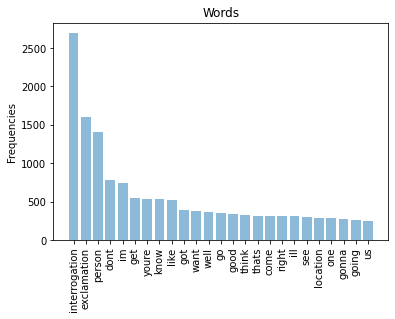

In [ ]:
plot_frequencies(top_train_df)

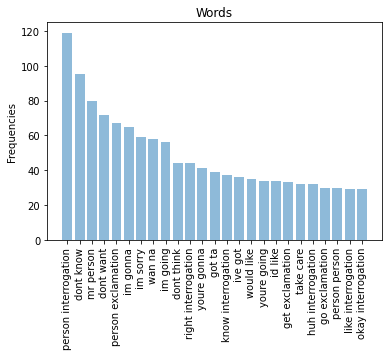

In [ ]:
top_train_df_2 = get_top_n_grams(train_df_bag["sentence"], top_k=25, n=2)
plot_frequencies(top_train_df_2)

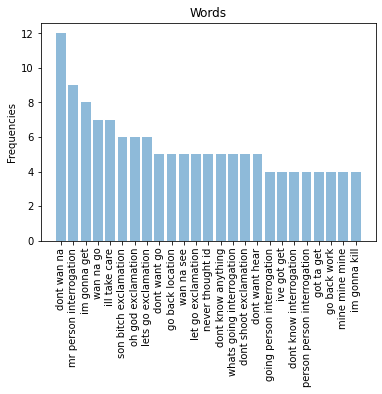

In [ ]:
top_train_df_3 = get_top_n_grams(train_df_bag["sentence"], top_k=25, n=3)
plot_frequencies(top_train_df_3)

## **Weaker Baselines**
### **Baseline #1**
**`BOW + KNN(7)`**

---

In [15]:
# Labels that will be used through out the models 
labels = {"Anger": 1, "Anticipation": 2, "Disgust": 3, "Fear": 4, "Joy": 5, "Sadness": 6, "Surprise": 7, "Trust": 8}

In [ ]:
base_modelknn_bow = KNeighborsClassifier(n_neighbors=7, weights='distance', algorithm='brute', leaf_size=30, p=2,
                                    metric='cosine', metric_params=None, n_jobs=1)
base_modelknn_bow.fit(X_bag,y_bag)

KNeighborsClassifier(algorithm='brute', metric='cosine', n_jobs=1,
                     n_neighbors=7, weights='distance')

In [ ]:
predict_base_bow = base_modelknn_bow.predict(X_dev_bag)

In [ ]:
print("\tResults for K-Nearest Neighbors with Bag-Of-Words\n")
print (classification_report(predict_base_bow, y_dev_bag, target_names=labels.keys()))

	Results for K-Nearest Neighbors with Bag-Of-Words

              precision    recall  f1-score   support

       Anger       0.51      0.33      0.40       321
Anticipation       0.31      0.29      0.30       180
     Disgust       0.09      0.16      0.11        45
        Fear       0.21      0.25      0.23        88
         Joy       0.28      0.30      0.29        91
     Sadness       0.17      0.22      0.19        69
    Surprise       0.23      0.27      0.25        83
       Trust       0.26      0.33      0.29       123

    accuracy                           0.29      1000
   macro avg       0.26      0.27      0.26      1000
weighted avg       0.33      0.29      0.30      1000



### **Baseline #1**
**`TF-IDF + KNN(7)`**

---

In [ ]:
base_modelknn_tfidf = KNeighborsClassifier(n_neighbors=7, weights='distance', algorithm='brute', leaf_size=30, p=2,
                                    metric='cosine', metric_params=None, n_jobs=1)
base_modelknn_tfidf.fit(X_tfidf,y_tfidf)

KNeighborsClassifier(algorithm='brute', metric='cosine', n_jobs=1,
                     n_neighbors=7, weights='distance')

In [ ]:
predict_base_tfidf = base_modelknn_tfidf.predict(X_dev_tfidf)

In [ ]:
print("\tResults for K-Nearest Neighbors with TF-IDF\n")
print (classification_report(predict_base_tfidf, y_dev_tfidf, target_names=labels.keys()))

	Results for K-Nearest Neighbors with TF-IDF

              precision    recall  f1-score   support

       Anger       0.49      0.34      0.40       307
Anticipation       0.35      0.33      0.34       177
     Disgust       0.09      0.28      0.14        25
        Fear       0.27      0.27      0.27       104
         Joy       0.34      0.33      0.33       101
     Sadness       0.21      0.26      0.23        68
    Surprise       0.26      0.35      0.30        72
       Trust       0.28      0.31      0.30       146

    accuracy                           0.32      1000
   macro avg       0.29      0.31      0.29      1000
weighted avg       0.35      0.32      0.33      1000



### **Baseline #2**
**`BOW + NB`**

---

In [ ]:
base_modelnb_bow = MultinomialNB().fit(X_bag, y_bag)

In [ ]:
predict_base2_bow = base_modelnb_bow.predict(X_dev_bag)

In [ ]:
print("\tResults for Naive-Bayes with Bag-Of-Words\n")
print (classification_report(predict_base2_bow, y_dev_bag, target_names=labels.keys()))

	Results for Naive-Bayes with Bag-Of-Words

              precision    recall  f1-score   support

       Anger       0.67      0.32      0.43       438
Anticipation       0.44      0.34      0.38       217
     Disgust       0.08      0.25      0.12        24
        Fear       0.18      0.38      0.25        50
         Joy       0.38      0.47      0.42        79
     Sadness       0.21      0.39      0.27        46
    Surprise       0.22      0.54      0.31        39
       Trust       0.27      0.40      0.32       107

    accuracy                           0.36      1000
   macro avg       0.31      0.39      0.31      1000
weighted avg       0.48      0.36      0.38      1000



### **Baseline #2**
**`TF-IDF + NB`**

---

In [ ]:
base_modelnb_tfidf = MultinomialNB().fit(X_tfidf, y_tfidf)

In [ ]:
predict_base2_tfidf = base_modelnb_tfidf.predict(X_dev_tfidf)

In [ ]:
print("\tResults for Naive-Bayes with TF-IDF\n")
print (classification_report(predict_base2_tfidf, y_dev_tfidf, target_names=labels.keys()))

	Results for Naive-Bayes with TF-IDF

              precision    recall  f1-score   support

       Anger       0.80      0.28      0.42       592
Anticipation       0.37      0.35      0.36       180
     Disgust       0.01      0.17      0.02         6
        Fear       0.08      0.40      0.13        20
         Joy       0.27      0.52      0.35        50
     Sadness       0.11      0.42      0.18        24
    Surprise       0.02      0.50      0.04         4
       Trust       0.35      0.44      0.39       124

    accuracy                           0.33      1000
   macro avg       0.25      0.39      0.24      1000
weighted avg       0.60      0.33      0.39      1000



### **Baseline #3**
**`BOW + SVM`**

---

In [ ]:
svcl_bow = svm.SVC(kernel = 'rbf', random_state = 42)

In [ ]:
svcl_bow.fit(X_bag, y_bag)

SVC(random_state=42)

In [ ]:
print("\tResults for Support Vector Machine with Bag-Of-Words\n")
y_pred_sv_bow = svcl_bow.predict(X_dev_bag)
print (classification_report(y_pred_sv_bow, y_dev_bag, target_names=labels.keys()))

	Results for Support Vector Machine with Bag-Of-Words

              precision    recall  f1-score   support

       Anger       0.64      0.33      0.44       405
Anticipation       0.41      0.39      0.40       181
     Disgust       0.04      0.25      0.07        12
        Fear       0.12      0.43      0.19        30
         Joy       0.37      0.44      0.40        81
     Sadness       0.16      0.32      0.21        44
    Surprise       0.28      0.37      0.32        73
       Trust       0.38      0.34      0.36       174

    accuracy                           0.36      1000
   macro avg       0.30      0.36      0.30      1000
weighted avg       0.46      0.36      0.38      1000



### **Baseline #3**
**`TDIDF + SVM`**

---

In [ ]:
svcl_tfidf = svm.SVC(kernel = 'rbf', random_state = 42)

In [ ]:
svcl_tfidf.fit(X_tfidf, y_tfidf)

SVC(random_state=42)

In [ ]:
print("\tResults for Support Vector Machine with TF-IDF\n")
y_pred_sv_tfidf = svcl_tfidf.predict(X_dev_tfidf)
print (classification_report(y_pred_sv_tfidf, y_dev_tfidf, target_names=labels.keys()))

	Results for Support Vector Machine with TF-IDF

              precision    recall  f1-score   support

       Anger       0.64      0.33      0.43       409
Anticipation       0.43      0.37      0.40       196
     Disgust       0.06      0.23      0.10        22
        Fear       0.16      0.34      0.22        50
         Joy       0.36      0.45      0.40        77
     Sadness       0.24      0.41      0.30        51
    Surprise       0.23      0.41      0.29        54
       Trust       0.35      0.40      0.37       141

    accuracy                           0.36      1000
   macro avg       0.31      0.37      0.32      1000
weighted avg       0.46      0.36      0.38      1000



## **Stronger Baselines**

#### **SMOTE**

In [ ]:
# Using SMOTE to balance out the dataset
oversample = SMOTE(random_state=42)

# Since the models that used TF-IDF showed better accuracy, we will only over populate X_tfidf
X_smote_tfidf, y_smote_tfidf = oversample.fit_resample(X_tfidf, y_tfidf)

### **Baseline #1**
**`SMOTE + TDIDF + SVM`**

---

In [ ]:
svcl_smote = svm.SVC(kernel='rbf', random_state=42).fit(X_smote_tfidf, y_smote_tfidf)
y_pred_sv_smote = svcl_smote.predict(X_dev_tfidf)

print("\tResults for Support Vector Machine with TF-IDF and SMOTE\n")
print (classification_report(y_pred_sv_smote, y_dev_tfidf, target_names=labels.keys()))

	Results for Support Vector Machine with TF-IDF and SMOTE

              precision    recall  f1-score   support

       Anger       0.51      0.33      0.40       329
Anticipation       0.38      0.41      0.39       160
     Disgust       0.14      0.18      0.16        61
        Fear       0.19      0.34      0.25        59
         Joy       0.37      0.38      0.38        94
     Sadness       0.31      0.39      0.35        69
    Surprise       0.36      0.36      0.36        97
       Trust       0.33      0.40      0.36       131

    accuracy                           0.35      1000
   macro avg       0.32      0.35      0.33      1000
weighted avg       0.38      0.35      0.36      1000



### **Baseline #1**
**`SMOTE + TDIDF + Lemmatization + SVM`**

---

In [ ]:
nltk.download('wordnet')
# TF-IDF Only
train_df_tfidf_l, X_tfidf_l, y_tfidf_l, cv_l = pipeline_data(train_df, 'sentence', tfidf=True, train=True, lemmatize=True)
dev_df_tfidf_l, X_dev_tfidf_l, y_dev_tfidf_l = pipeline_data(dev_df, 'sentence', tfidf=True, cv=cv_l, lemmatize=True)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


100%|██████████| 1000/1000 [00:00<00:00, 1629.26it/s]


In [ ]:
# SMOTE
X_smote_tfidf_l, y_smote_tfidf_l = oversample.fit_resample(X_tfidf_l, y_tfidf_l)

In [ ]:
svcl_smote_l = svm.SVC(kernel='rbf', random_state=42).fit(X_smote_tfidf_l, y_smote_tfidf_l)
y_pred_sv_smote_l = svcl_smote_l.predict(X_dev_tfidf_l)

print("\tResults for Support Vector Machine with TF-IDF, Lemmatization and SMOTE\n")
print (classification_report(y_pred_sv_smote_l, y_dev_tfidf_l, target_names=labels.keys()))

	Results for Support Vector Machine with TF-IDF, Lemmatization and SMOTE

              precision    recall  f1-score   support

       Anger       0.52      0.33      0.40       330
Anticipation       0.39      0.40      0.39       165
     Disgust       0.14      0.19      0.16        59
        Fear       0.19      0.35      0.25        57
         Joy       0.36      0.39      0.37        90
     Sadness       0.29      0.39      0.33        64
    Surprise       0.36      0.34      0.35       103
       Trust       0.32      0.39      0.35       132

    accuracy                           0.35      1000
   macro avg       0.32      0.35      0.33      1000
weighted avg       0.38      0.35      0.36      1000



### **Baseline #1**
**`SMOTE + TDIDF + Stemming + SVM`**

---

In [ ]:
# TF-IDF Only
train_df_tfidf_s, X_tfidf_s, y_tfidf_s, cv_s = pipeline_data(train_df, 'sentence', tfidf=True, train=True, stemmer=True)
dev_df_tfidf_s, X_dev_tfidf_s, y_dev_tfidf_s = pipeline_data(dev_df, 'sentence', tfidf=True, cv=cv_s, stemmer=True)

100%|██████████| 1000/1000 [00:00<00:00, 3734.36it/s]


In [ ]:
# SMOTE
X_smote_tfidf_s, y_smote_tfidf_s = oversample.fit_resample(X_tfidf_s, y_tfidf_s)

In [ ]:
svcl_smote_s = svm.SVC(kernel='rbf', random_state=42).fit(X_smote_tfidf_s, y_smote_tfidf_s)
y_pred_sv_smote_s = svcl_smote_s.predict(X_dev_tfidf_s)

print("\tResults for Support Vector Machine with TF-IDF, Stemming and SMOTE\n")
print (classification_report(y_pred_sv_smote_s, y_dev_tfidf_s, target_names=labels.keys()))

	Results for Support Vector Machine with TF-IDF, Stemming and SMOTE

              precision    recall  f1-score   support

       Anger       0.50      0.34      0.40       308
Anticipation       0.35      0.37      0.36       164
     Disgust       0.14      0.19      0.16        57
        Fear       0.18      0.31      0.23        62
         Joy       0.37      0.39      0.38        92
     Sadness       0.28      0.35      0.31        68
    Surprise       0.32      0.32      0.32        96
       Trust       0.34      0.35      0.35       153

    accuracy                           0.34      1000
   macro avg       0.31      0.33      0.31      1000
weighted avg       0.37      0.34      0.35      1000



### **Baseline #2**
**`BERT`**

---

In [17]:
train_df2 = deepcopy(train_df)
dev_df2 = deepcopy(dev_df)

In [18]:
train_df2["emotion"].replace({8: 0}, inplace=True)
dev_df2["emotion"].replace({8: 0}, inplace=True)

In [31]:
# Labels that will be used through out the models 
labels2 = {"Anger": 1, "Anticipation": 2, "Disgust": 3, "Fear": 4, "Joy": 5, "Sadness": 6, "Surprise": 7, "Trust": 0}

In [2]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = TFBertModel.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [20]:
x_train = tokenizer(
    text=train_df2.sentence.tolist(),
    add_special_tokens=True,
    max_length=32,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_dev = tokenizer(
    text=dev_df2.sentence.tolist(),
    add_special_tokens=True,
    max_length=32,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [7]:
input_ids = x_train["input_ids"]
attention_mask = x_train['attention_mask']

In [21]:
max_len = 32
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(8,activation = 'sigmoid')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [22]:
optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss = CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = metric
)

In [23]:
y_train = train_df2.emotion.to_numpy()
y_dev = dev_df2.emotion.to_numpy()

y_train = to_categorical(y_train, 8)
y_dev = to_categorical(y_dev, 8)

In [24]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_dev['input_ids'],'attention_mask':x_dev['attention_mask']}, y_dev
    ),
  epochs=2,
    batch_size=36
)

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


389/389 [==============================] - 125s 268ms/step - loss: 1.2898 - balanced_accuracy: 0.5526 - val_loss: 1.4088 - val_balanced_accuracy: 0.5220
Epoch 2/2
389/389 [==============================] - 104s 268ms/step - loss: 0.9937 - balanced_accuracy: 0.6634 - val_loss: 1.4780 - val_balanced_accuracy: 0.5180


In [32]:
predicted_raw = model.predict({'input_ids':x_dev['input_ids'],'attention_mask':x_dev['attention_mask']})
predicted_raw[0]

array([0.7176171 , 0.6693337 , 0.9301009 , 0.5644908 , 0.83018905,
       0.41234833, 0.1483541 , 0.8227766 ], dtype=float32)

In [34]:
y_predicted = np.argmax(predicted_raw, axis = 1)
y_true = dev_df2.emotion

In [35]:
print(classification_report(y_true, y_predicted, target_names=labels2.keys()))

              precision    recall  f1-score   support

       Anger       0.59      0.44      0.51       158
Anticipation       0.53      0.62      0.57       211
     Disgust       0.55      0.53      0.54       170
        Fear       0.49      0.38      0.43        77
         Joy       0.46      0.55      0.50       104
     Sadness       0.57      0.61      0.59        97
    Surprise       0.44      0.47      0.45        87
       Trust       0.46      0.43      0.44        96

    accuracy                           0.52      1000
   macro avg       0.51      0.50      0.50      1000
weighted avg       0.52      0.52      0.52      1000



### **Baseline #2**
**`BERT with class_weights`**

---

In [36]:
class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced', 
    classes = np.unique(train_df2.emotion), 
    y = train_df2.emotion)
class_weights = dict(zip(np.unique(train_df2.emotion), class_weights))
class_weights

{0: 0.8353221957040573,
 1: 0.5835278426142048,
 2: 0.8219821512447159,
 3: 1.3030528667163068,
 4: 1.2135922330097086,
 5: 1.1904761904761905,
 6: 1.2644508670520231,
 7: 1.5377855887521967}

In [38]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_dev['input_ids'],'attention_mask':x_dev['attention_mask']}, y_dev
    ),
  epochs=2,
    batch_size=36,
    class_weight=class_weights,
)

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


389/389 [==============================] - 117s 261ms/step - loss: 0.8581 - balanced_accuracy: 0.7059 - val_loss: 1.5733 - val_balanced_accuracy: 0.5130
Epoch 2/2
389/389 [==============================] - 104s 268ms/step - loss: 0.7758 - balanced_accuracy: 0.7322 - val_loss: 1.6217 - val_balanced_accuracy: 0.5040


In [39]:
predicted_raw = model.predict({'input_ids':x_dev['input_ids'],'attention_mask':x_dev['attention_mask']})
predicted_raw[0]

array([0.7572606 , 0.56604624, 0.95320046, 0.6889708 , 0.83460796,
       0.38270035, 0.10159112, 0.92239106], dtype=float32)

In [40]:
y_predicted = np.argmax(predicted_raw, axis = 1)
y_true = dev_df2.emotion

In [41]:
print(classification_report(y_true, y_predicted, target_names=labels2.keys()))

              precision    recall  f1-score   support

       Anger       0.64      0.47      0.54       158
Anticipation       0.54      0.51      0.52       211
     Disgust       0.58      0.50      0.54       170
        Fear       0.39      0.40      0.40        77
         Joy       0.43      0.53      0.48       104
     Sadness       0.52      0.67      0.59        97
    Surprise       0.41      0.52      0.46        87
       Trust       0.43      0.43      0.43        96

    accuracy                           0.50      1000
   macro avg       0.49      0.50      0.49      1000
weighted avg       0.51      0.50      0.50      1000



## **Generating the Predictions**
**`test_df + BERT`**

---

In [42]:
# RUN THIS CELL

dev_df_forpredict = deepcopy(dev_df)
test_df_forpredict = deepcopy(test_df)

In [ ]:
# RUN THIS CELL

train_df2 = deepcopy(train_df)
train_df2["emotion"].replace({8: 0}, inplace=True)
dev_df2["emotion"].replace({8: 0}, inplace=True)

In [44]:
# RUN THIS CELL

def_sentences = dev_df_forpredict.sentence.values.tolist()
test_sentences = test_df_forpredict.sentence.values.tolist()

In [45]:
# RUN THIS CELL

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert = TFBertModel.from_pretrained("bert-base-uncased")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [46]:
# RUN THIS CELL

x_train = tokenizer(
    text=train_df2.sentence.tolist(),
    add_special_tokens=True,
    max_length=32,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_dev = tokenizer(
    text=dev_df_forpredict.sentence.tolist(),
    add_special_tokens=True,
    max_length=32,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test = tokenizer(
    text=test_df_forpredict.sentence.tolist(),
    add_special_tokens=True,
    max_length=32,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [47]:
# RUN THIS CELL

input_ids = x_train["input_ids"]
attention_mask = x_train['attention_mask']

In [48]:
# RUN THIS CELL

max_len = 32
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(8,activation = 'sigmoid')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [49]:
# RUN THIS CELL

optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss = CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = metric
)

In [50]:
# RUN THIS CELL

y_train = train_df2.emotion.to_numpy()
y_train = to_categorical(y_train, 8)

In [51]:
# RUN THIS CELL

train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train, epochs=2, batch_size=36
)

Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


389/389 [==============================] - 120s 253ms/step - loss: 1.5797 - balanced_accuracy: 0.4286
Epoch 2/2
389/389 [==============================] - 102s 261ms/step - loss: 1.2540 - balanced_accuracy: 0.5571


In [52]:
# RUN THIS CELL

predicted_raw_dev = model.predict({'input_ids':x_dev['input_ids'],'attention_mask':x_dev['attention_mask']})
predicted_raw_dev[0]

array([0.05984972, 0.44142893, 0.6798714 , 0.23831868, 0.8703401 ,
       0.09985086, 0.26592982, 0.51188296], dtype=float32)

In [53]:
# RUN THIS CELL

predicted_raw_test = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
predicted_raw_test[0]

array([0.74485314, 0.42329812, 0.974957  , 0.37644058, 0.30169773,
       0.4671512 , 0.09974864, 0.14269628], dtype=float32)

In [54]:
# RUN THIS CELL

y_predicted_dev = np.argmax(predicted_raw_dev, axis = 1)
y_predicted_test = np.argmax(predicted_raw_test, axis = 1)

y_predicted_dev = y_predicted_dev.tolist()
y_predicted_test = y_predicted_test.tolist()

In [55]:
print("Number of predicted labels for dev: " + str(len(y_predicted_dev)))
print("Number of sentences in def_df: " + str(len(dev_df_forpredict.sentence)))

Number of predicted labels for dev: 1000
Number of sentences in def_df: 1000


In [56]:
print("Number of predicted labels for dev: " + str(len(y_predicted_test)))
print("Number of sentences in def_df: " + str(len(test_df_forpredict.sentence)))

Number of predicted labels for dev: 2000
Number of sentences in def_df: 2000


In [60]:
for i in range(len(y_predicted_dev)):
    if y_predicted_dev[i] == 0:
      y_predicted_dev[i] = 8

for i in range(len(y_predicted_test)):
    if y_predicted_test[i] == 0:
      y_predicted_test[i] = 8

In [65]:
dev_final = []
for i in range(len(def_sentences)):
  dev_final.append(def_sentences[i]+'\t'+str(y_predicted_dev[i]))

test_final = []
for i in range(len(test_sentences)):
  test_final.append(test_sentences[i]+'\t'+str(y_predicted_test[i]))

In [66]:
with open("/content/drive/MyDrive/NOVA IMS/Text Mining/dev_results.txt", 'a') as f:
    f.writelines('\n'.join(dev_final))

In [67]:
with open("/content/drive/MyDrive/NOVA IMS/Text Mining/test_results.txt", 'a') as f:
    f.writelines('\n'.join(test_final))